# Assignment 1

In [80]:
import skimage
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from skimage.color import rgb2gray
from skimage.feature import canny
from sklearn.metrics import roc_curve

# Defining filters

In [81]:
sobel_x = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])
sobel_y = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])
roberts_x = np.array([
    [1,0],
    [0,-1]
])
roberts_y = np.array([
    [0,1],
    [-1,0]
])

scharr_x = np.array([
    [-3,0,3],
    [-10,0,-10],
    [-3,0,3]
])

scharr_y = np.array([
    [-3,-10,-3],
    [0,0,0],
    [3,10,3]
])

laplacian_4middle = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])
laplacian_8middle = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])


first_order_gaussian_filter_1d_length5 = np.array([
    [0.1897,0.1741,0,-0.1741,-0.1897]
])

#generate the 2d Gaussian filter by matrix multiplication
first_order_gaussian_filter_2d = np.matmul(np.transpose(first_order_gaussian_filter_1d_length5), first_order_gaussian_filter_1d_length5)

gaussian_filter_1d_length5 = np.array([
    [0.0545,0.2442,0.4026,0.2442,0.0545]
])
gaussian_filter_3x3 = np.array([
    [0.0113,0.0838,0.0113],
    [0.0838,0.6193,0.0838],
    [0.0113,0.0838,0.0113]
])
gaussian_filter_5x5 = np.array([
 [0.00297025, 0.0133089,  0.0219417,  0.0133089,  0.00297025],
 [0.0133089,  0.05963364, 0.09831492, 0.05963364, 0.0133089 ],
 [0.0219417,  0.09831492, 0.16208676, 0.09831492, 0.0219417 ],
 [0.0133089,  0.05963364, 0.09831492, 0.05963364, 0.0133089 ],
 [0.00297025, 0.0133089,  0.0219417,  0.0133089 , 0.00297025]
])

# Defining basic functions    

In [82]:
def show_rgb_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV

    mpl.rcParams['figure.dpi'] =  300


    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

def show_binary_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV

    # Show the image

    plt.imshow(image, cmap=plt.cm.gray)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

def zero_cross(image):   
    z_c_image = np.zeros(image.shape)
    thresh = np.absolute(image).mean() * 0.75
    h,w = image.shape
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            patch = image[y-1:y+2, x-1:x+2]
            p = image[y, x]
            maxP = patch.max()
            minP = patch.min()
            if (p > 0):
                zeroCross = True if minP < 0 else False
            else:
                zeroCross = True if maxP > 0 else False
            if ((maxP - minP) > thresh) and zeroCross:
                z_c_image[y, x] = 1
    return z_c_image

def magnitude(x,y):
    x_sqr = np.square(x)
    y_sqr = np.square(y)
    m = np.sqrt(x_sqr + y_sqr)
    return m


# Task 1. Laplacian of Gaussian

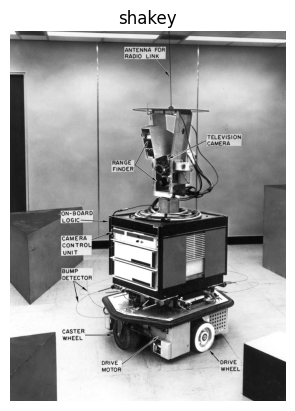

In [83]:
# Read and show shakey
shakey = skimage.io.imread("shakey.150.gif")[0]
plt.imshow(shakey,cmap = 'gray')
plt.title('shakey')
plt.axis('off')
plt.show()

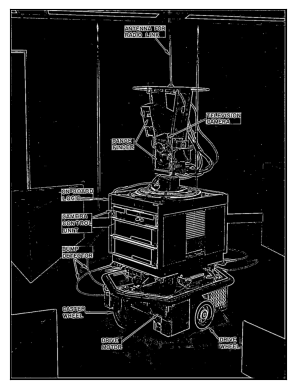

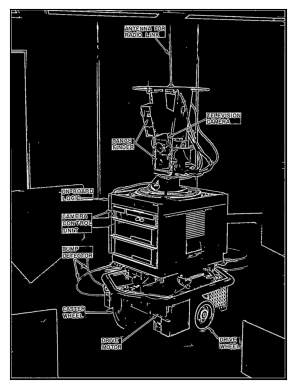

In [84]:
# Create the Laplacian of Gaussian filter   
# scipy.signal.convolve2d takes two 2d arrays as inputs and convolve them together  
lap_of_gau = scipy.signal.convolve2d(gaussian_filter_5x5, laplacian_8middle)

# Apply the Laplacian of gaussian filter to the image
sky_log = scipy.signal.convolve2d(shakey, lap_of_gau)

# Apply hysteresis thresholding to improve the quality of the filtered image
show_binary_image(sky_log>20)
sky_log_hysteresised = skimage.filters.apply_hysteresis_threshold(sky_log, 10, 50)
show_binary_image(sky_log_hysteresised)

# Task 2 && Task 3: Edge Detection

In [85]:
# 1-ground truths image to make the result consistent with filtered original images
cell_1 = rgb2gray(skimage.io.imread('cells/9343 AM.bmp'))
cell_1_truth = 1-rgb2gray(skimage.io.imread('cells/9343 AM Edges.bmp'))
 
cell_2 = rgb2gray(skimage.io.imread('cells/10905 JL.bmp'))
cell_2_truth = 1-rgb2gray(skimage.io.imread('cells/10905 JL Edges.bmp'))

cell_3 = rgb2gray(skimage.io.imread('cells/43590 AM.bmp'))
cell_3_truth = 1-rgb2gray(skimage.io.imread('cells/43590 AM Edges.bmp'))


In [86]:
# Takes 2 compulsary arguments and 1 optional argument so it can handle all filters (except for canny)
def applySomeFilter(image, filter1, filter2 = None):
    if filter2 is not None:
        image_x = scipy.signal.convolve2d(image, filter1, mode = 'same', boundary='fill', fillvalue=0)
        image_y = scipy.signal.convolve2d(image, filter2, mode = 'same', boundary='fill', fillvalue=0)
        filtered = magnitude(image_x, image_y)
    else:
        filtered = scipy.signal.convolve2d(image, filter1, mode = 'same', boundary='fill', fillvalue=0)
    return filtered

In [214]:
# Apply all the filters to the same image and return all the results in an array 
def applyAllFiltersTo(image):
    robertsed = applySomeFilter(image, roberts_x, roberts_y)
    sobeled = applySomeFilter(image, sobel_x, sobel_y)
    firstOrderGaussianed= applySomeFilter(image, first_order_gaussian_filter_2d)
    laplacianed = applySomeFilter(image, laplacian_8middle)
    laplacianOfGaussianed = applySomeFilter(image, lap_of_gau)
    cannyed_1 = canny(image, sigma=1)
    cannyed_3 = canny(image, sigma=3)
    scharred = applySomeFilter(image, scharr_x, scharr_y)

    imageSmoothed = applySomeFilter(image, gaussian_filter_5x5)
    image_x_1st = scipy.signal.convolve2d(imageSmoothed,sobel_x, mode = 'same', boundary='fill', fillvalue=0)
    image_x_2nd = scipy.signal.convolve2d(image_x_1st,sobel_x, mode = 'same', boundary='fill', fillvalue=0)
    image_y_1st = scipy.signal.convolve2d(imageSmoothed,sobel_y, mode = 'same', boundary='fill', fillvalue=0)
    image_y_2nd = scipy.signal.convolve2d(image_y_1st,sobel_y, mode = 'same', boundary='fill', fillvalue=0)
    gauAndLapByHand = magnitude(image_x_2nd,image_y_2nd)
    
    
    return [robertsed, sobeled, firstOrderGaussianed, laplacianed, 
            laplacianOfGaussianed, cannyed_1, cannyed_3, scharred, gauAndLapByHand]

In [181]:
def hysAll(images):
    rob_hysed = skimage.filters.apply_hysteresis_threshold(images[0], 0.01, 0.02)
    sobel_hysed = skimage.filters.apply_hysteresis_threshold(images[1], 0.05, 0.2)
    fstOrderGasu_hysed = skimage.filters.apply_hysteresis_threshold(images[2], 0.001, 0.005)
    lap_hysed = skimage.filters.apply_hysteresis_threshold(images[3], 0.005, 0.1)
    lapOfGau_hysed = skimage.filters.apply_hysteresis_threshold(images[4], 0.005, 0.05)
    scharr_hysed = skimage.filters.apply_hysteresis_threshold(images[7], 2, 3)
    gauAndLapByHand = skimage.filters.apply_hysteresis_threshold(images[8], 0.2, 0.6)
    
    return [rob_hysed, sobel_hysed, fstOrderGasu_hysed, lap_hysed, lapOfGau_hysed, 
            images[5], images[6], scharr_hysed, gauAndLapByHand]

In [208]:
cell_1_filteredByAllFilters = applyAllFiltersTo(cell_1)
cell_2_filteredByAllFilters = applyAllFiltersTo(cell_2)
cell_3_filteredByAllFilters = applyAllFiltersTo(cell_3)

In [90]:
def displayBasics(images):
    plt.figure(figsize=(15, 5))  # Adjust the size as needed

    plt.subplot(1, 5, 1)
    plt.imshow(images[0], cmap='gray')
    plt.axis('off')  # Hide axes ticks and labels
    plt.title('Roberts')

    plt.subplot(1, 5, 2)
    plt.imshow(images[1], cmap='gray')
    plt.axis('off')
    plt.title('Sobel')

    plt.subplot(1, 5, 3)
    plt.imshow(images[2], cmap='gray')
    plt.axis('off')
    plt.title('Fst order Gau')

    plt.subplot(1, 5, 4)
    plt.imshow(images[3], cmap='gray')
    plt.axis('off')
    plt.title('Laplacian')

    plt.subplot(1, 5, 5)
    plt.imshow(images[4], cmap='gray')
    plt.axis('off')
    plt.title('Lap of Gau')

    plt.tight_layout()
    plt.show()   

In [152]:
def displayAdvanced(images):
    plt.figure(figsize=(15, 5))  # Adjust the size as needed

    plt.subplot(1, 4, 1)
    plt.imshow(images[5], cmap='gray')
    plt.axis('off')  # Hide axes ticks and labels
    plt.title('Canny_sigma1 ')

    plt.subplot(1, 4, 2)
    plt.imshow(images[6], cmap='gray')
    plt.axis('off')
    plt.title('Canny_sigma3')

    plt.subplot(1, 4, 3)
    plt.imshow(images[7], cmap='gray')
    plt.axis('off')
    plt.title('Scharr')

    plt.subplot(1, 4, 4)
    plt.imshow(images[8], cmap='gray')
    plt.axis('off')
    plt.title('LapOfGauByhand')

    plt.tight_layout()
    plt.show()

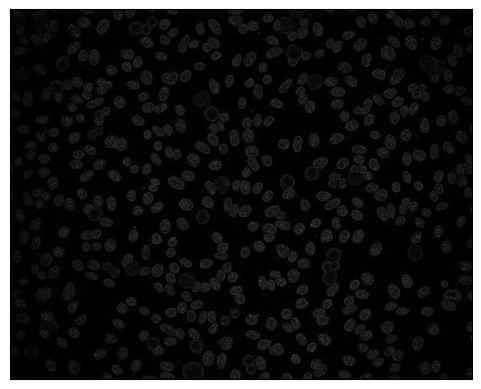

In [196]:
show_binary_image(cell_1_filteredByAllFilters[0])

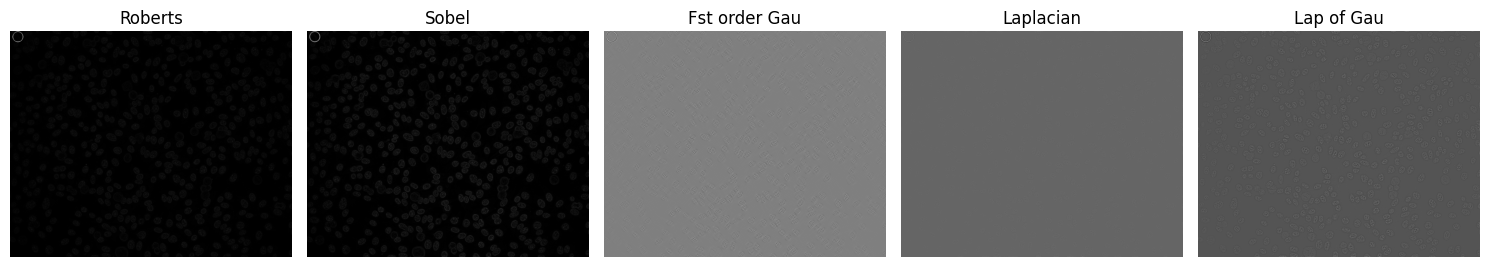

In [209]:
displayBasics(cell_1_filteredByAllFilters)

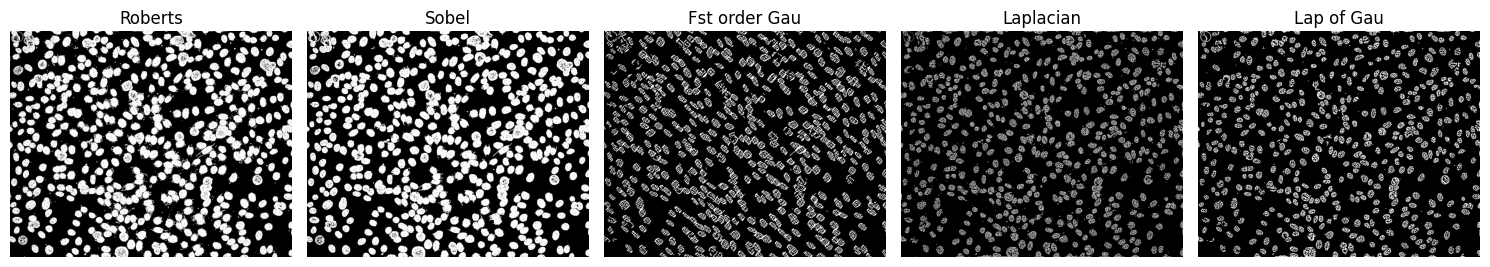

In [210]:
displayBasics(hysAll(cell_1_filteredByAllFilters))

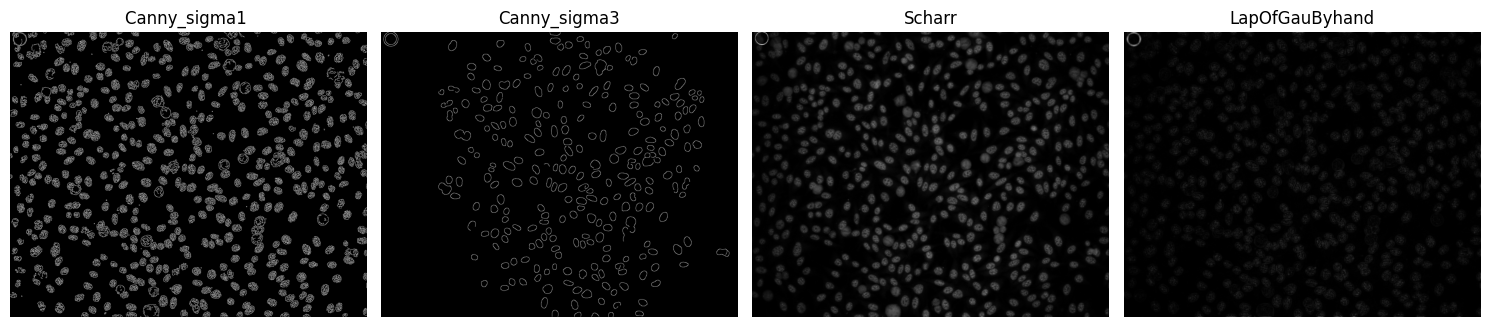

In [217]:
displayAdvanced(cell_1_filteredByAllFilters)

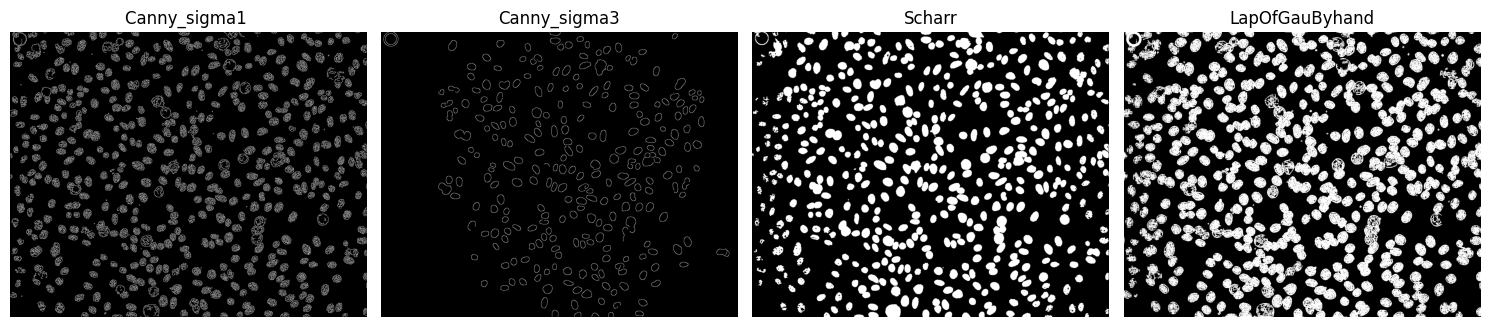

In [218]:
displayAdvanced(hysAll(cell_1_filteredByAllFilters))

# Task 4: Result evaluation

In [198]:
def rocIt(images,truth):
    # Calculate the ROC curves
    flatTruth = truth.flatten()
    imagesFlattened = [image.flatten() for image in images]

    fpr_rob, tpr_rob, thd_rob          = roc_curve(flatTruth, imagesFlattened[0])   # False Positive Rate, True Positive Rate
    fpr_sob, tpr_sob, thd_sob          = roc_curve(flatTruth, imagesFlattened[1]) 
    fpr_fog, tpr_fog, thd_fog          = roc_curve(flatTruth, imagesFlattened[2]) 
    fpr_lap, tpr_lap, thd_lap          = roc_curve(flatTruth, imagesFlattened[3]) 
    fpr_log, tpr_log, thd_log          = roc_curve(flatTruth, imagesFlattened[4]) 
    fpr_canny1, tpr_canny1, thd_canny1 = roc_curve(flatTruth, imagesFlattened[5])
    fpr_canny3, tpr_canny3, thd_canny3 = roc_curve(flatTruth, imagesFlattened[6]) 
    fpr_sch, tpr_sch, thd_sch          = roc_curve(flatTruth, imagesFlattened[7]) 
    fpr_lapByhand, tpr_lapByhand, thd_lapByhand  = roc_curve(flatTruth, imagesFlattened[8]) 


    plt.plot(fpr_rob, tpr_rob, label='Roberts')
    plt.plot(fpr_sob, tpr_sob, label='Sobel')
    plt.plot(fpr_fog, tpr_fog, label='Fst order Gau')
    plt.plot(fpr_lap, tpr_lap, label='Laplacian')
    plt.plot(fpr_log, tpr_log, label='Lap of Gau')
    plt.plot(fpr_canny1, tpr_canny1, label='Canny 1')
    plt.plot(fpr_canny3, tpr_canny3, label='Canny 3')
    plt.plot(fpr_sch, tpr_sch, label='Scharr')
    plt.plot(fpr_lapByhand, tpr_lapByhand, label='LapOfGauByHand')
    plt.plot([0,1], [0,1], 'k--', label = 'no filter')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

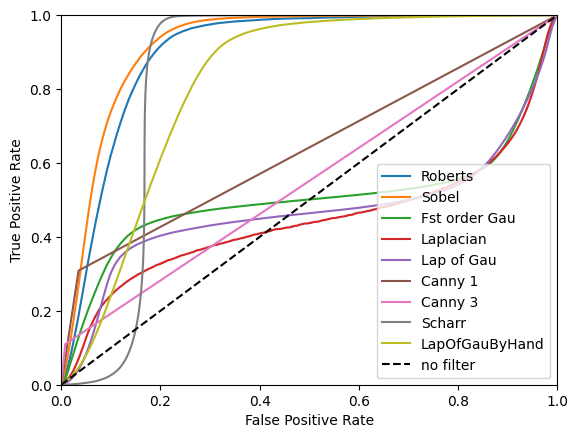

In [199]:
rocIt(cell_1_filteredByAllFilters, cell_1_truth) 

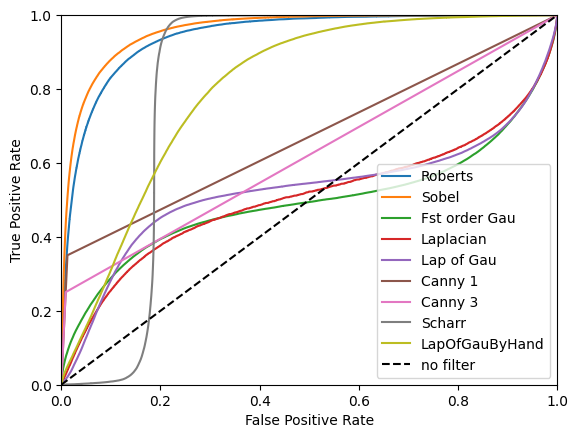

In [200]:
rocIt(cell_2_filteredByAllFilters, cell_2_truth) 

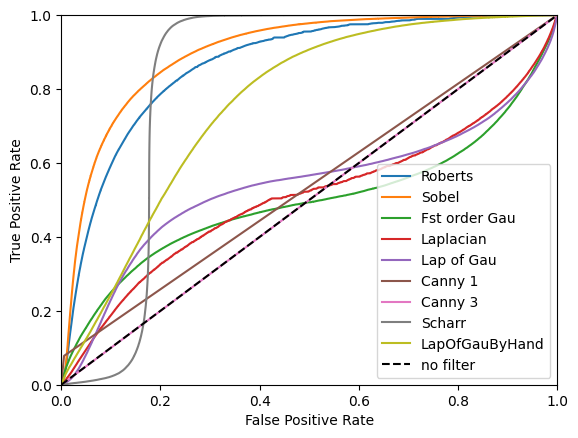

In [201]:
rocIt(cell_3_filteredByAllFilters, cell_3_truth) 

# Task 4: F1 score